<center><h1>Facial Emotion Detection</h1></center>

In [2]:
!pip install scikit-plot

# Importing the dependencies and Libraries 

In [2]:
import pandas as pd
import numpy as np
import scikitplot
import random
import seaborn as sns
import keras

from sklearn.preprocessing import StandardScaler
from sklearnex import patch_sklearn
from matplotlib import pyplot
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
import warnings
from tensorflow.keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras import regularizers
from keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.optimizers import Adam,RMSprop,SGD,Adamax
from keras.preprocessing.image import ImageDataGenerator,load_img

from keras.layers import Conv2D, MaxPool2D, Flatten,Dense,Dropout,BatchNormalization,MaxPooling2D,Activation,Input
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
warnings.simplefilter("ignore")
from keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from keras.regularizers import l1, l2
import plotly.express as px
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [3]:
from tensorflow.keras.utils import plot_model

# Importing the Dataset

Importing the dataset which consist of image pixels along with the emotions

In [4]:
data = pd.read_csv("fer2013.csv")
data.shape

(35887, 3)

**Missing data Calculation**

Checking whether any of the data's have null value 

In [5]:
data.isnull().sum()

emotion    0
pixels     0
Usage      0
dtype: int64

**Visualizing the dataset**

In [6]:
data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


# Data pre-processing

**Shuffling the data**

In [7]:
data = data.sample(frac=1)

**Encoding the labels**

In [8]:
labels = to_categorical(data[['emotion']], num_classes=7)

**Changing image pixels to Numpy array**

Converting pixels into np array so the model can be trained to classify the emotions

In [9]:
train_pixels = data["pixels"].astype(str).str.split(" ").tolist()
train_pixels = np.uint8(train_pixels)

**Reshaping the np array of pixels**

In [10]:
pixels = train_pixels.reshape((35887*2304,1))

**Standardization**

Converting pixels with long range into range of 0 to 1 so that the training of model takes less time

In [11]:
scaler = StandardScaler()
pixels = scaler.fit_transform(pixels)

In [12]:
pixels = train_pixels.reshape((35887, 48, 48,1))

**Spliting the dataset into Training set, Test set, Validation set**

In [13]:
X_train, X_test, y_train, y_test = train_test_split(pixels, labels, test_size=0.1, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, shuffle=False)

In [14]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(29068, 48, 48, 1)
(3589, 48, 48, 1)
(3230, 48, 48, 1)


<h3>Visulazing the images</h3>

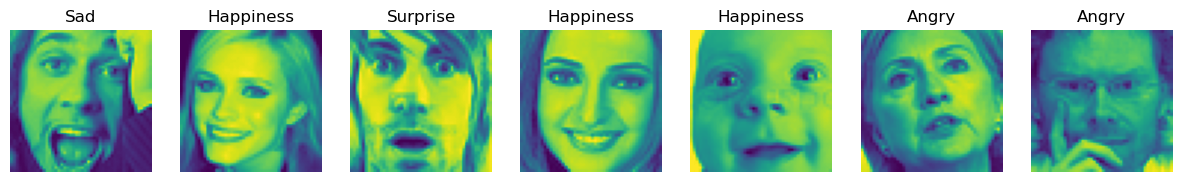

In [15]:
plt.figure(figsize=(15,23))
label_dict = {0 : 'Angry', 1 : 'Disgust', 2 : 'Fear', 3 : 'Happiness', 4 : 'Sad', 5 : 'Surprise', 6 : 'Neutral'}
i = 1
for i in range (7):
    img = np.squeeze(X_train[i])
    plt.subplot(1,7,i+1)
    plt.imshow(img)
    index = np.argmax(y_train[i])
    plt.title(label_dict[index])
    plt.axis('off')
    i += 1
plt.show()

 <h3>Data augmentation using ImageDataGenerator</h3>

Data augmentation is a technique of artificially increasing the training set by creating modified copies of a dataset using existing data. It includes making minor changes to the dataset or using deep learning to generate new data points.  

In [16]:
data_gen = ImageDataGenerator(  width_shift_range = 0.1,
                               height_shift_range = 0.1,
                               horizontal_flip = True,
                               zoom_range = 0.2)
valid_gen = ImageDataGenerator(   width_shift_range = 0.1,
                               height_shift_range = 0.1,
                               horizontal_flip = True,
                               zoom_range = 0.2) 

In [17]:
data_gen.fit(X_train)
valid_gen.fit(X_val)

In [18]:
train_generator = data_gen.flow(X_train, y_train, batch_size=64)
val_generator = data_gen.flow(X_val, y_val, batch_size=64)

<h1>Creating Deep Learning Model</h1>

In [19]:
def cnn_model():
    #Initialising the CNN
    model= tf.keras.models.Sequential()
    # First Convolution layer
    model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(48, 48,1)))
    # Second Convolution layer
    model.add(Conv2D(64,(3,3), padding='same', activation='relu' ))
    model.add(BatchNormalization())
    # Pooling
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    # Adding third convolutional layer
    model.add(Conv2D(128,(5,5), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
      
    # Adding fourth convolutional layer
    model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    # Adding fifth convolutional layer
    model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    # Adding sixth convolutional layer
    model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    # Flattening
    model.add(Flatten()) 
    
    # creating Full Connection
    model.add(Dense(256,activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
      
    model.add(Dense(512,activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    model.add(Dense(7, activation='softmax'))
   
    return model

**Creating a model by calling cnn_model function**

In [20]:
model = cnn_model()

**Compiling the deep learning model with adam optimizer with learning rate of 0.0001**

In [21]:
 model.compile(optimizer = Adam(lr=0.0001), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])

**Visualizing the complete model using summary() function**

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 batch_normalization (Batch  (None, 48, 48, 64)        256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 128)       2

**Early stopping**

Adding checkpointer to implement Early Stopping to prevent overfitting.

In [23]:
checkpointer = [EarlyStopping(monitor = 'val_accuracy', 
                              verbose = 1, 
                              restore_best_weights=True,
                              mode="max",
                              patience = 5),
                ModelCheckpoint('best_model.h5',
                                monitor="val_accuracy",
                                verbose=1,
                                save_best_only=True,
                                mode="max")]

**Training the model**

Fitting model with training dataset set and 30 epochs

In [24]:
history = model.fit(train_generator,
                    epochs=30,
                    batch_size=64,   
                    verbose=1,
                    callbacks=[checkpointer],
                    validation_data=val_generator)

Epoch 1/30
455/455 [==============================] - ETA: 0s - loss: 6.7834 - accuracy: 0.2188
Epoch 1: val_accuracy improved from -inf to 0.18019, saving model to best_model.h5
455/455 [==============================] - 382s 839ms/step - loss: 6.7834 - accuracy: 0.2188 - val_loss: 2.9004 - val_accuracy: 0.1802
Epoch 2/30
455/455 [==============================] - ETA: 0s - loss: 2.5659 - accuracy: 0.3012
Epoch 2: val_accuracy improved from 0.18019 to 0.29783, saving model to best_model.h5
455/455 [==============================] - 365s 802ms/step - loss: 2.5659 - accuracy: 0.3012 - val_loss: 2.7093 - val_accuracy: 0.2978
Epoch 3/30
455/455 [==============================] - ETA: 0s - loss: 2.6669 - accuracy: 0.3863
Epoch 3: val_accuracy improved from 0.29783 to 0.33344, saving model to best_model.h5
455/455 [==============================] - 375s 824ms/step - loss: 2.6669 - accuracy: 0.3863 - val_loss: 2.8992 - val_accuracy: 0.3334
Epoch 4/30
455/455 [==============================] 

# Visualizing results

**Loss Plot**

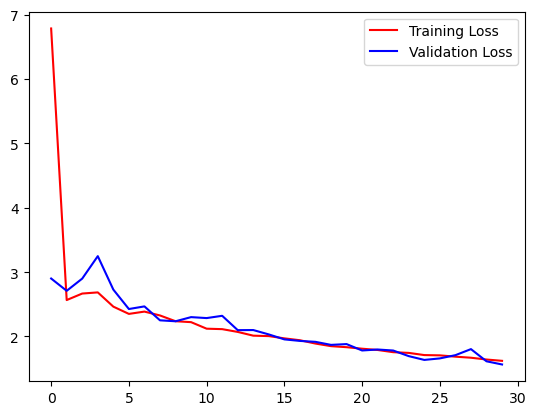

In [25]:
plt.plot(history.history["loss"],'r', label="Training Loss")
plt.plot(history.history["val_loss"],'b', label="Validation Loss")
plt.legend()

**Accuracy of the model**

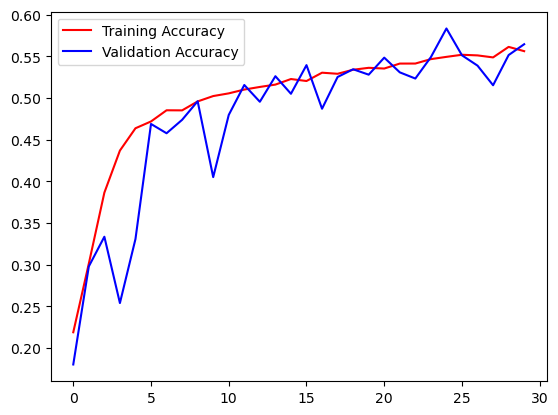

In [26]:
plt.plot(history.history["accuracy"],'r',label="Training Accuracy")
plt.plot(history.history["val_accuracy"],'b',label="Validation Accuracy")
plt.legend()

**Evaluating the Accuracy of the model**

In [27]:
loss = model.evaluate(X_test,y_test) 
print("Test Acc: " + str(loss[1]))

113/113 [==============================] - 13s 114ms/step - loss: 1.6415 - accuracy: 0.5717
Test Acc: 0.5717470049858093


**Predicting Emotion**

In [28]:
preds = model.predict(X_test)
y_pred = np.argmax(preds , axis = 1 )

113/113 [==============================] - 13s 114ms/step


**Visualizing the predictions**

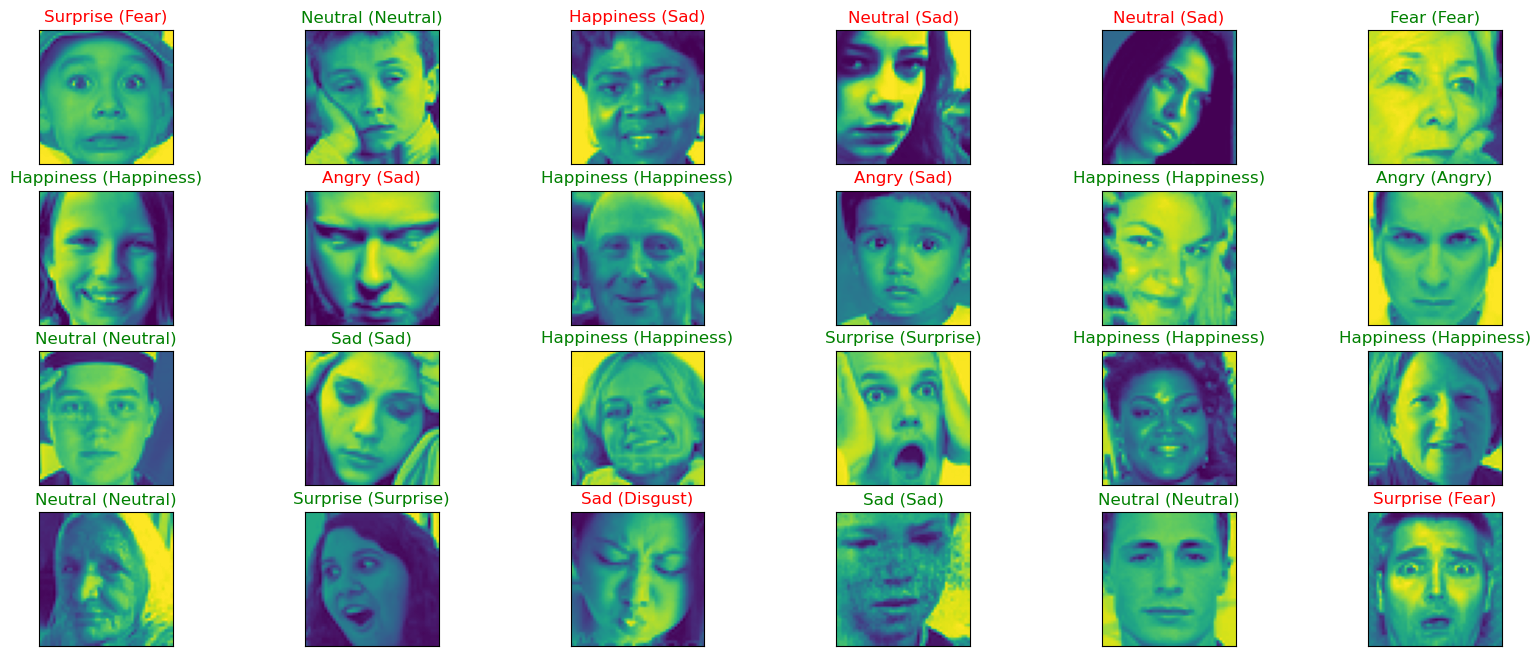

In [29]:
label_dict = {0 : 'Angry', 1 : 'Disgust', 2 : 'Fear', 3 : 'Happiness', 4 : 'Sad', 5 : 'Surprise', 6 : 'Neutral'}

figure = plt.figure(figsize=(20, 8))
for i, index in enumerate(np.random.choice(X_test.shape[0], size=24, replace=False)):
    ax = figure.add_subplot(4, 6, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(X_test[index]))
    predict_index = label_dict[(y_pred[index])]
    true_index = label_dict[np.argmax(y_test,axis=1)[index]]
    
    ax.set_title("{} ({})".format((predict_index), 
                                  (true_index)),
                                  color=("green" if predict_index == true_index else "red"))

**Visualizing the classification report which consist of f1_score, precision , recall and support of 7 classes**

In [30]:
from sklearn.metrics import classification_report
print(classification_report(np.argmax(y_test, axis = 1 ),y_pred,digits=3))

              precision    recall  f1-score   support

           0      0.442     0.529     0.482       512
           1      0.000     0.000     0.000        68
           2      0.476     0.111     0.180       542
           3      0.773     0.865     0.816       849
           4      0.426     0.474     0.449       612
           5      0.684     0.768     0.723       439
           6      0.495     0.635     0.556       567

    accuracy                          0.572      3589
   macro avg      0.471     0.483     0.458      3589
weighted avg      0.552     0.572     0.542      3589



Visualizing confusion Matrix for analysing the Predictions

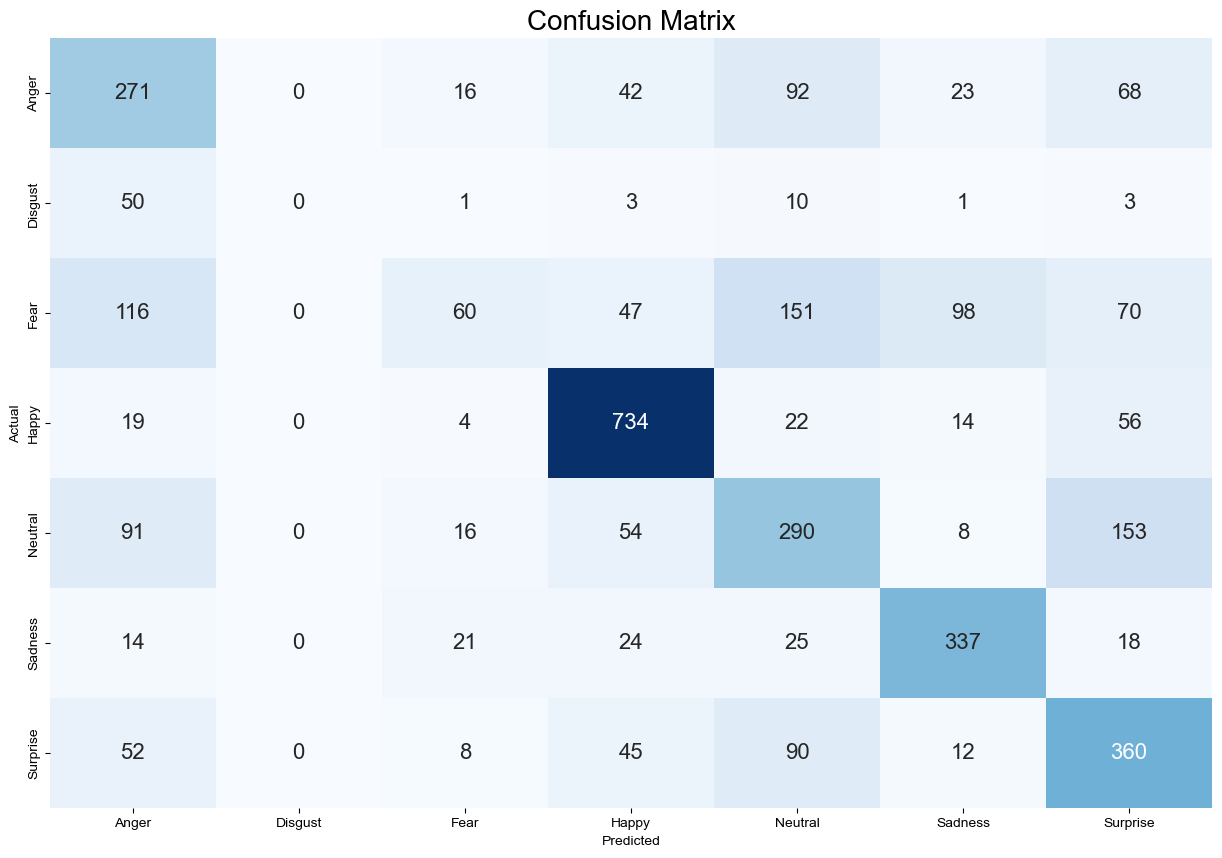

In [31]:
CLASS_LABELS  = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sadness', "Surprise"]

cm_data = confusion_matrix(np.argmax(y_test, axis = 1 ), y_pred)
cm = pd.DataFrame(cm_data, columns=CLASS_LABELS, index = CLASS_LABELS)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize = (15,10))
plt.title('Confusion Matrix', fontsize = 20)
sns.set(font_scale=1.2)
ax = sns.heatmap(cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g')

# Changing optimizer

Creating Deep learning model by calling cnn_model method

In [32]:
model = cnn_model()

Compiling model with SGD optimizer 

In [33]:
model.compile(optimizer=tf.keras.optimizers.SGD(0.001),
                loss='categorical_crossentropy',
                metrics = ['accuracy'])

Training the model with 30 epochs 

In [34]:
history = model.fit(train_generator,
                    epochs=30,
                    batch_size=64,   
                    verbose=1,
                    callbacks=[checkpointer],
                    validation_data=val_generator)

Epoch 1/30
455/455 [==============================] - ETA: 0s - loss: 14.7786 - accuracy: 0.1660
Epoch 1: val_accuracy did not improve from 0.58328
455/455 [==============================] - 901s 2s/step - loss: 14.7786 - accuracy: 0.1660 - val_loss: 14.1064 - val_accuracy: 0.1672
Epoch 2/30
455/455 [==============================] - ETA: 0s - loss: 14.3694 - accuracy: 0.1800
Epoch 2: val_accuracy did not improve from 0.58328
455/455 [==============================] - 3545s 8s/step - loss: 14.3694 - accuracy: 0.1800 - val_loss: 13.8315 - val_accuracy: 0.1950
Epoch 3/30
455/455 [==============================] - ETA: 0s - loss: 14.0352 - accuracy: 0.1901
Epoch 3: val_accuracy did not improve from 0.58328
455/455 [==============================] - 361s 793ms/step - loss: 14.0352 - accuracy: 0.1901 - val_loss: 13.5555 - val_accuracy: 0.2461
Epoch 4/30
455/455 [==============================] - ETA: 0s - loss: 13.7527 - accuracy: 0.1991
Epoch 4: val_accuracy did not improve from 0.58328
45

Checking the accuracy of the model

In [35]:
loss = model.evaluate(X_test,y_test) 
print("Test Acc: " + str(loss[1]))

113/113 [==============================] - 14s 126ms/step - loss: 12.8840 - accuracy: 0.2661
Test Acc: 0.26609084010124207


**Visualizing the Loss**

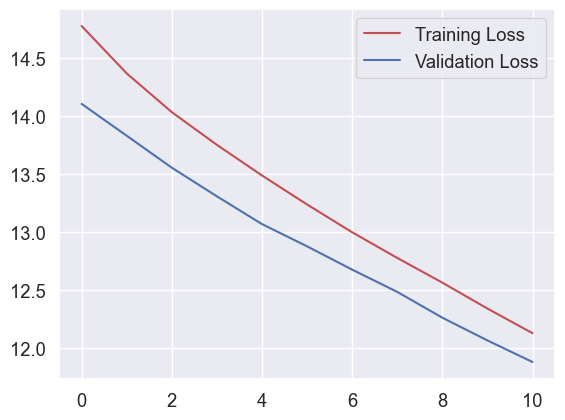

In [36]:
plt.plot(history.history["loss"],'r', label="Training Loss")
plt.plot(history.history["val_loss"],'b', label="Validation Loss")
plt.legend()

**Visualizing the accuracy**

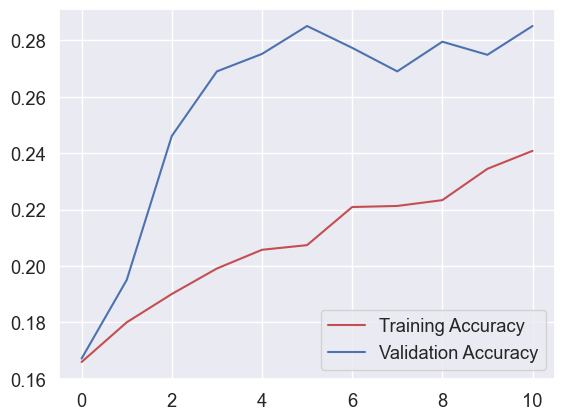

In [37]:
plt.plot(history.history["accuracy"],'r',label="Training Accuracy")
plt.plot(history.history["val_accuracy"],'b',label="Validation Accuracy")
plt.legend()

# Increasing no of epochs

Increasing no of epochs so that the model fits well along with the dataset

In [38]:
model = cnn_model()

Compiling model with adam optimizer with 0.0001 learning rate

In [39]:
model.compile(
    optimizer = Adam(lr=0.0001), 
    loss='categorical_crossentropy', 
    metrics=['accuracy'])

In [40]:
checkpointer = [EarlyStopping(monitor = 'val_accuracy', verbose = 1, 
                              restore_best_weights=True,mode="max",patience = 10),
                              ModelCheckpoint('best_model.h5',monitor="val_accuracy",verbose=1,
                              save_best_only=True,mode="max")]

Fitting the model with 50 epochs

In [41]:
history = model.fit(train_generator,
                    epochs=50,
                    batch_size=64,   
                    verbose=1,
                    callbacks=[checkpointer],
                    validation_data=val_generator)

Epoch 1/50
455/455 [==============================] - ETA: 0s - loss: 6.6857 - accuracy: 0.2230
Epoch 1: val_accuracy improved from -inf to 0.21796, saving model to best_model.h5
455/455 [==============================] - 426s 934ms/step - loss: 6.6857 - accuracy: 0.2230 - val_loss: 2.7243 - val_accuracy: 0.2180
Epoch 2/50
455/455 [==============================] - ETA: 0s - loss: 2.6111 - accuracy: 0.3051
Epoch 2: val_accuracy improved from 0.21796 to 0.32755, saving model to best_model.h5
455/455 [==============================] - 400s 878ms/step - loss: 2.6111 - accuracy: 0.3051 - val_loss: 2.8347 - val_accuracy: 0.3276
Epoch 3/50
455/455 [==============================] - ETA: 0s - loss: 2.5948 - accuracy: 0.4041
Epoch 3: val_accuracy improved from 0.32755 to 0.36811, saving model to best_model.h5
455/455 [==============================] - 431s 947ms/step - loss: 2.5948 - accuracy: 0.4041 - val_loss: 2.5768 - val_accuracy: 0.3681
Epoch 4/50
455/455 [==============================] 

**Calculating the Accuracy of the model**

In [42]:
loss = model.evaluate(X_test,y_test) 
print("Test Acc: " + str(loss[1]))

113/113 [==============================] - 13s 117ms/step - loss: 1.4769 - accuracy: 0.5653
Test Acc: 0.5653385519981384


**Predicting the emotions of Test dataset**

In [43]:
preds = model.predict(X_test)
y_pred = np.argmax(preds , axis = 1 )

113/113 [==============================] - 11s 97ms/step


**Displaying Confusion matrix**

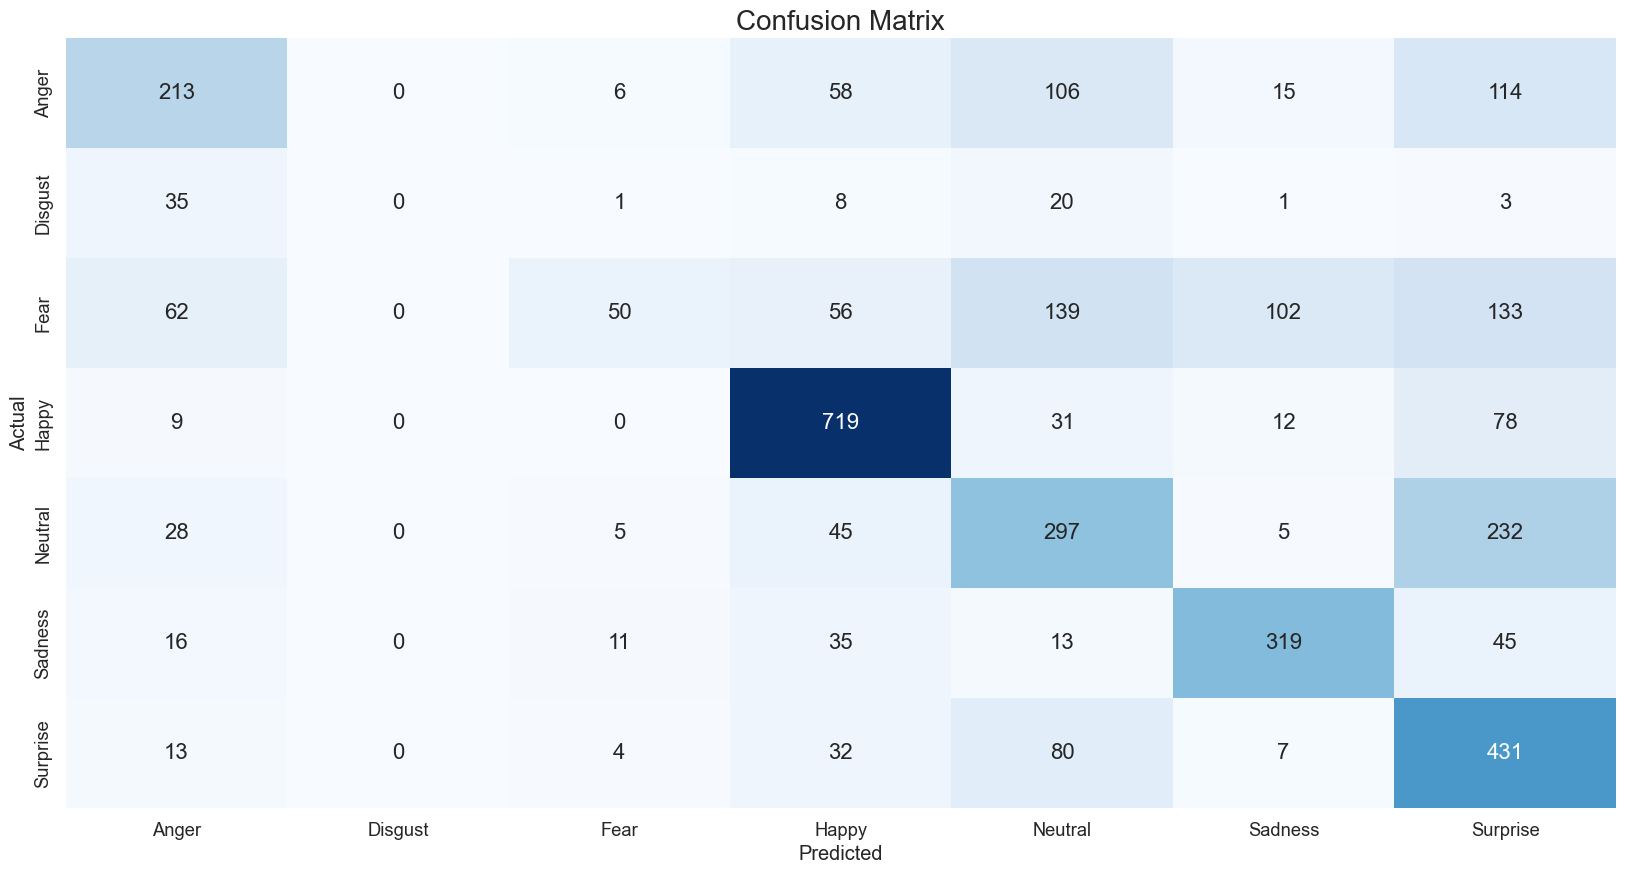

In [44]:
CLASS_LABELS  = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sadness', "Surprise"]

cm_data = confusion_matrix(np.argmax(y_test, axis = 1 ), y_pred)
cm = pd.DataFrame(cm_data, columns=CLASS_LABELS, index = CLASS_LABELS)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize = (20,10))
plt.title('Confusion Matrix', fontsize = 20)
sns.set(font_scale=1.2)
ax = sns.heatmap(cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g')

**Visualizing Classification Report**

In [45]:
print(classification_report(np.argmax(y_test, axis = 1 ),y_pred,digits=3))

              precision    recall  f1-score   support

           0      0.566     0.416     0.480       512
           1      0.000     0.000     0.000        68
           2      0.649     0.092     0.162       542
           3      0.754     0.847     0.798       849
           4      0.433     0.485     0.458       612
           5      0.692     0.727     0.709       439
           6      0.416     0.760     0.538       567

    accuracy                          0.565      3589
   macro avg      0.502     0.475     0.449      3589
weighted avg      0.582     0.565     0.531      3589

